# Library

In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squigglepy as sq
import datetime as dt

from squigglepy import bayes
from squigglepy.numbers import K, M, B, T
from copy import deepcopy
from scipy import stats
from pprint import pprint
from collections import Counter
from tqdm import tqdm

%matplotlib inline
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

Loaded 1
Loaded 2


In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 100*K                                      # Number of runs to do (default 100*K)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)


years = range(CURRENT_YEAR, MAX_YEAR)
print('Loaded')


Loaded


# Model

### TAI Scenarios

In [3]:
# Conditoinal on making TAI, will it be agentic?
p_make_agent_tai = 0.9

# Conditional on making agentic TAI, will it be aligned by default?
p_tai_aligned_by_default = 0.3

# Conditional on making agentic TAI that is not aligned by default, will we solve the alignment problem?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_solved(war, year, first_attempt=True, verbose=False):
    if first_attempt:
        p = min(0.1 + 1.6 * (year/45), 0.7)
    else:
        p = min(0.1 + 2 * (year/45), 0.9)
    if verbose == 2:
        print('* alignment solve diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p
# TODO: Convert to logistic curves


# Conditional on making agentic TAI that is not aligned by default, will we successfully coordinate to deploy safe AI?
# Varies by year, whether this is the first attempt, and whether there is a great power war
def p_alignment_deployment_safety_and_coordination(war, year, first_attempt=True, verbose=False):
    if year <= 2030 - CURRENT_YEAR and not war:
        p = 0.8
    elif war:
        p = 0.4
    else:
        p = 0.6
    if first_attempt is False:
        p += 0.1
    p = min(p, 0.95)
    p = max(p, 0.05)
    if verbose == 2:
        print('* alignment coordination diagnostic - war: {} year: {} first attempt: {} -> p {})'.format(war, year, first_attempt, p))
    return p

# Conditional on solving the alignment problem, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved = 0.85

# Conditional on alignment by default, what is the chance we also solve the subtle misalignment problem?
p_subtle_alignment_solved_if_aligned_by_default = 0.4

# Conditional on having agentic TAI, will it be intentionally misused to create a singleton?
def p_tai_intentional_misuse(war):
    return 0.3 if war else 0.05

# If TAI is fully misaligned what is the chance we can successfully detect and avert this?
p_full_tai_misalignment_averted = 0.15

# If TAI is fully misaligned but successfully averted, what is the probability there will be a catasrophe (10%+ death)?
p_tai_misalignment_averting_is_catastrophic = 0.4

# If TAI is fully misaligned and we successfully avert it, what is the chance we give up on TAI?
p_full_tai_misalignment_averted_means_abandoned_tai = 0.7

# If TAI is fully misaligned, what is the chance it results in extinction versus a singleton?
p_tai_xrisk_is_extinction = 0.4

# If there is a fully misaligned TAI singleton, what is the chance it results in a non-extinction catastrophe (10%+ death)?
p_tai_singleton_is_catastrophic = 0.8


exec(open('modules/tai_risk.py').read())
print('Loaded TAI scenarios module')


Loaded TAI scenarios module


### Nuclear Scenarios Module

In [4]:
def p_russia_uses_nuke(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2023:
        return 0.03
    else:
        return 0.001 / peace

    
p_nk_uses_nuke = 0.001


def p_china_invades_taiwan(peace, year):
    peace = 10 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022:
        return 0
    elif year == 2023:
        return 0.01
    elif year == 2024 or year == 2025:
        return 0.047   # makes cumulative probability by EOY 2025 = 0.1
                        # solve 0.01 + (1-0.01)*X + (1-0.01)(1-X)*X = 0.1, 0>X<1
    elif year < 2030:
        return 0.078 # makes cumulative probability by EOY 2029 = 0.4
                     # solve 0.1 + (1-0.1)*X + (1-0.1)(1-X)*X + (1-0.1)(1-X)^2*X + (1-0.1)(1-X)^3*X + (1-0.1)(1-X)^4*X = 0.4
    elif year < 2035:
        return 0.097 # makes cumulative probability by EOY 2034 = 0.6
                     # 0.4 + (1-0.5)*X + (1-0.5)(1-X)*X + (1-0.5)(1-X)^2*X + (1-0.5)(1-X)^3*X + (1-0.5)(1-X)^4*X = 0.6
    else:
        return 0.005 / peace


def p_china_uses_nuke(peace, year):
    return p_china_invades_taiwan(peace, year) * 0.01

    
def p_other_uses_nuke(peace):
    peace = 10 if peace else 1
    return 0.0002 / peace


# What is the chance in a given year there will be a "nuclear accident"?
def p_nuclear_accident(war, year):
    p = 0.05 if war else 0.02
    p = p * (0.998 ** year)
    return p


# Conditional on a nuclear accident, what is the chance it escalates into an "exchange"?
def p_nuclear_accident_becomes_exchange(war):
    return 0.2 if war else 0.05


# Conditional on a nuclear exchange, what is the chance it escalates into a catastrophe (10%+ dead)?
def p_catastrophe_from_nuclear_exchange(war):
    p_exchange_becomes_all_out_war = 0.6 if war else 0.3
    p_nuclear_winter_happens = 0.3
    alternative_foods_or_other_save = 0.05
    return (p_exchange_becomes_all_out_war *
            (p_nuclear_winter_happens + (1 - p_nuclear_winter_happens) * 0.1) *
            (1 - alternative_foods_or_other_save))
    
    
# Conditional on a nuclear exchange catastrophe, what is the chance it becomes an xrisk?
p_xrisk_from_nuclear_catastrophe = 0.05 # https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would


# Conditional on a great power war, what is the chance it goes intentionally nuclear in any given year?
def p_nuclear_exchange_given_war(first_year_of_war):
    return 0.1 if first_year_of_war else 0.02


exec(open('modules/nuclear.py').read())
print('Loaded nuclear scenarios module')


Loaded nuclear scenarios module


### Great Power War Scenarios Module

In [5]:
def p_great_power_war_us_russia_without_nuke_first(peace, year):
    peace = 20 if peace else 1
    year = year + CURRENT_YEAR
    if year == 2022 or year == 2023:
        return (0.02 / 2) / peace
    else:
        return 0.003 / peace

    
def p_great_power_war_us_china(peace, year):
    peace = 20 if peace else 1
    p_invade_taiwan = p_china_invades_taiwan(peace, year)
    p_us_responds = 0.6
    return p_invade_taiwan * p_us_responds

    
def p_great_power_war_other(peace, year):
    peace = 5 if peace else 1
    year = year + CURRENT_YEAR
    if year > 2040:
        return 0.005 / peace
    else:
        return 0.001 / peace


# Conditional on a great power war starting, how long will it last?
war_length = sq.lognorm(2, 50) # 90% CI

# After a war ends, how long will there be a peace?
peace_length = sq.lognorm(10, 100)


exec(open('modules/great_power_war.py').read())
print('Loaded great power war scenarios module')


Loaded great power war scenarios module


### Bio scenarios module

In [6]:
# Conditional on a great power war, what is the annual chance it intentionally results in a bioweapon?
p_biowar_given_war = 1/800

# What is the annual chance of a non-state actor creating an intentional biorisk that causes 1%+ death?
p_nonstate_bio = 1/1200

# What is the chance that if 1%+ die from natural bio, 10%+ will die from natural bio?
p_natural_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# What is the chance that if 1%+ die from engineered bio, 10%+ will die from engineered bio?
p_engineered_bio_is_catastrophe = 1 / (10 ** 0.5) # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

p_covid_spanish_flu_like_becomes_1pct_death = 1 / (10 ** 0.5) # https://www.economist.com/graphic-detail/coronavirus-excess-deaths-estimates suggests COVID killed 0.2%... https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028 suggests 1% is 2x less likely than 0.2%
p_covid_lab_leak = 0.3
p_extinction_given_90_pct_death = 0.03 # per Luisa https://forum.effectivealtruism.org/posts/GsjmufaebreiaivF7/what-is-the-likelihood-that-civilizational-collapse-would
p_accidental_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028
p_intentional_catastrophe_causes_90_pct_death = (1 / (10 ** 0.5)) ** 2 # https://www.liebertpub.com/doi/pdfplus/10.1089/hs.2017.0028

# If a lab leak occurs, how likely is it that the leaked pandemic will be engineered vs. natural?
ratio_engineered_vs_natural_lab_leak = 0.8

# What is the chance of an natural biorisk/pandemic causing 1%+ population death?
def p_natural_bio(year):
    base_rate_from_covid_and_spanish_flu = 1/250
    increase_from_globalization = 1.1
    decreate_in_rate_per_year_from_improvements = 0.99 ** year
    return ((base_rate_from_covid_and_spanish_flu * 0.5 +
             base_rate_from_covid_and_spanish_flu * (1 - p_covid_lab_leak) * 0.5) *
            increase_from_globalization *
            p_covid_spanish_flu_like_becomes_1pct_death *
            decreate_in_rate_per_year_from_improvements)
    
    
# What is the chance of an accidental biorisk (e.g., lab leak) causing 1%+ population death?
def p_accidental_bio(war):
    base_rate_from_covid = 0.01 * p_covid_lab_leak
    increase_factor_due_to_increasing_labs = 1.3
    increase_factor_due_to_great_power_war = 2
    p = (base_rate_from_covid *
         p_covid_spanish_flu_like_becomes_1pct_death *
         increase_factor_due_to_increasing_labs)
    return p * increase_factor_due_to_great_power_war if war else p
    

# Conditional on a accidental biorisk (1% death), what is the chance it becomes a xrisk?
def p_xrisk_from_accidental_bio_given_catastrophe(year):
    return p_accidental_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


# Conditional on a bioweapon, what is the chance it becomes a xrisk?
def p_xrisk_from_engineered_bio_given_catastrophe(year):
    return p_intentional_catastrophe_causes_90_pct_death * p_extinction_given_90_pct_death


exec(open('modules/bio.py').read())
print('Loaded bio scenarios module')


Loaded bio scenarios module


### Nanotech scenarios module

In [7]:
# What is the chance in a given year that nanotech will be developed?
def p_nanotech_possible(year):
    return 0.0001 / (0.956 ** year) # TODO: This goes over 1


# Conditional on developing nanotech, what is the chance nanotech results in an xrisk?
p_nanotech_is_xrisk = 0.1 * 0.05


exec(open('modules/nano.py').read())
print('Loaded nano scenarios module')


Loaded nano scenarios module


### Supervolcano scenarios module (all other natural risks <0.01%)

In [8]:
p_supervolcano_catastrophe = 1 / (500*K)  # https://www.openphilanthropy.org/research/large-volcanic-eruptions/ VEI >= 9 (geometric mean of 30K and 30M)

p_supervolcano_extinction_given_catastrophe = 0.05


exec(open('modules/supervolcano.py').read())
print('Loaded supervolcano module')


Loaded supervolcano module


### Unknown unknown scenarios module

In [9]:
# What is the chance in any given year that an unknown unknown xrisk occurs?
def p_unknown_unknown_xrisk(year):
    return (1 / (100*K)) / (0.99 ** year) # TODO: This goes over 1
    
exec(open('modules/unknown_unknown.py').read())
print('Loaded unknown unknown scenarios module')


Loaded unknown unknown scenarios module


### Double dip catastrophe module

In [10]:
p_extinction_from_double_catastrophe = 0.1
extinction_from_double_catastrophe_range = 10

exec(open('modules/double_dip_catastrophe.py').read())
print('Loaded double dip catastrophe module')

Loaded double dip catastrophe module


### AI Timeline variables

In [11]:
if_catastrophe_delay_tai_arrival_by_years = sq.lognorm(2, 10)
if_us_china_war_delay_tai_arrival_by_years = sq.lognorm(2, 10)

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')

print('-')
tai_years = bayes.bayesnet(load_cache_file='caches/tai_years', verbose=True)

print('-')
print('Loaded')


Loaded TAI timelines module
-
Loading from cache file (`caches/tai_years.sqcache`)...
...Loaded
Caching in-memory...
...Cached!
...Reducing
...Reduced!
...All done!
-
Loaded


## Model output

In [12]:
exec(open('modules/define_event.py').read())
print('Model loaded')

for i in range(20):
    print('############')
    print('## RUN {} ##'.format(i + 1))
    print('############')
    define_event(verbosity=2)

Model loaded
############
## RUN 1 ##
############
2026: WAR!!! (US vs. China)
...US-China war delays TAI by 7 years
2029: War ends :)
--- /!\ TAI CREATED in 2097
2098: ...XRISK from subtly unaligned TAI :(
...Total loop complete in 17.93ms
-
-
############
## RUN 2 ##
############
2027: Russia uses a nuke first strike (outside of great power war)!
2027: WAR!!! (US vs. Russia)
--- /!\ TAI CREATED in 2032
2033: ...successfully coordinated to not deploy unsafe TAI
2034: ...successfully coordinated to not deploy unsafe TAI
2035: ...successfully coordinated to not deploy unsafe TAI
2036: ...successfully coordinated to not deploy unsafe TAI
2037: ...successfully coordinated to not deploy unsafe TAI
2038: War ends :)
2038: ...XRISK from subtly unaligned TAI :(
...Total loop complete in 11.55ms
-
-
############
## RUN 3 ##
############
--- /!\ TAI CREATED in 2028
2029: ...Achieved aligned TAI (aligned via work, 2nd+ attempt), happy future! :D
...Total loop complete in 10.53ms
-
-
############

In [13]:
%%time
collectors = bayes.bayesnet(define_event,
                            find=lambda e: e['collectors'],
                            load_cache_file='caches/future_assessment_model_cache',
                            dump_cache_file='caches/future_assessment_model_cache',
                            reload_cache=True, #False,
                            raw=True,
                            verbose=True,
                            cores=5,
                            n=RUNS)

Reloading cache...
Generating Bayes net with 5 cores...


100%|███████████████████████████████████████████████████████| 100000/100000 [08:04<00:00, 206.44it/s]


Shuffling data...
Waiting for other cores...


100%|██████████████████████████████████████████████████████████████████| 5/5 [01:21<00:00, 16.32s/it]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/future_assessment_model_cache.sqcache`...
...Cached!
...Finding
...Found!
...All done!
CPU times: user 8min 51s, sys: 40.9 s, total: 9min 32s
Wall time: 10min


## Core Analysis

4E. When TAI?
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2027',
 '10%: 2028',
 '15%: 2029',
 '20%: 2030',
 '25%: 2031',
 '35%: 2035',
 '50%: 2043',
 '60%: 2051',
 '75%: 2108',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 4 years from now',
 '10%: 5 years from now',
 '15%: 6 years from now',
 '20%: 7 years from now',
 '25%: 8 years from now',
 '35%: 12 years from now',
 '50%: 20 years from now',
 '60%: 28 years from now',
 '75%: 85 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 1.9%
2024-2027: 2.1%
2028-2029: 15.2%
2030-2034: 14.6%
2035-2039: 10.0%
2040-2049: 14.1%
2050-2059: 8.8%
2060-2069: 4.4%
2070-2079: 1.9%
2080-2089: 1.0%
2090-2099: 0.6%
2100-2109: 0.5%
2110-2119: 0.5%
>2120: 24.5%
-
## TAI ARRIVAL DATE BY YEAR - COMPARE TO BENCHMARK ##
By EOY 2024: 1.9%
By EOY 2025: 2.3%
By EOY 2027: 8.4% (within 5 yrs)
By EOY 2030: 23

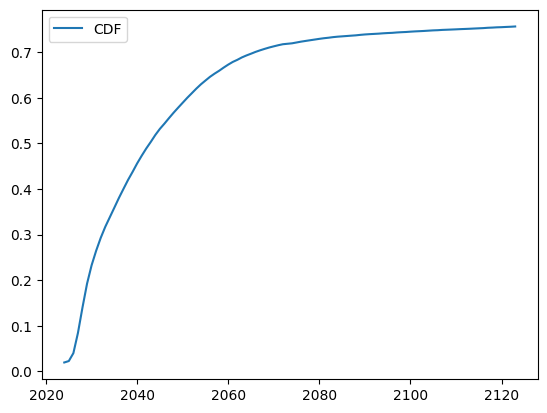

<string>:111: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:112: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

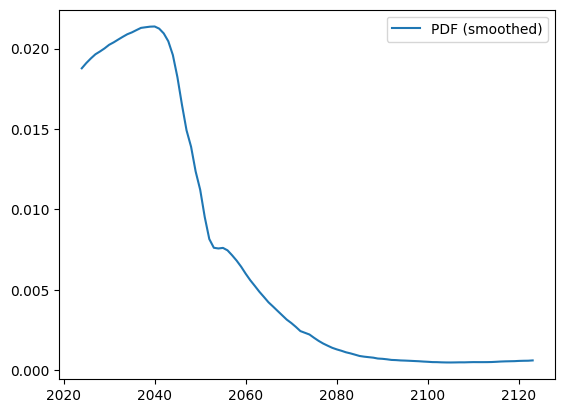

In [14]:
print('4E. When TAI?')
print('-')

yrs = bayes.bayesnet(define_event,
                     find=lambda e: e['final_state']['tai_year'],
                     raw=True,
                     n=RUNS)
yrs = [MAX_YEAR + 1 if y is None else y for y in yrs]
print_tai_arrival_stats(yrs)

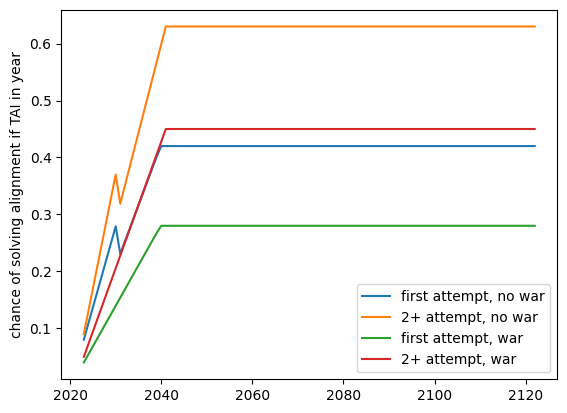

In [15]:
alignment_p = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=True) * p_alignment_deployment_safety_and_coordination(war=False, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2 = np.array([p_alignment_solved(war=False, year=y - CURRENT_YEAR, first_attempt=False) * p_alignment_deployment_safety_and_coordination(war=False, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
alignment_pwar = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=True) * p_alignment_deployment_safety_and_coordination(war=True, year=y - CURRENT_YEAR, first_attempt=True) for y in years])
alignment_p2war = np.array([p_alignment_solved(war=True, year=y - CURRENT_YEAR, first_attempt=False) * p_alignment_deployment_safety_and_coordination(war=True, year=y - CURRENT_YEAR, first_attempt=False) for y in years])
plt.plot(years, alignment_p, label='first attempt, no war')
plt.plot(years, alignment_p2, label='2+ attempt, no war')
plt.plot(years, alignment_pwar, label='first attempt, war')
plt.plot(years, alignment_p2war, label='2+ attempt, war')
plt.legend()
plt.ylabel('chance of solving alignment if TAI in year')
plt.show()


In [16]:
for y in list(years[:17]) + list(years[17::10]):
    str_ = 'Year: {} - chance of solving TAI alignment with war {}% (2nd attempt {}%) -- or no war {}% (2nd attempt {}%)'
    print(str_.format(y,
                      round(alignment_pwar[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2war[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p[y - CURRENT_YEAR] * 100, 0),
                      round(alignment_p2[y - CURRENT_YEAR] * 100, 0)))

Year: 2023 - chance of solving TAI alignment with war 4.0% (2nd attempt 5.0%) -- or no war 8.0% (2nd attempt 9.0%)
Year: 2024 - chance of solving TAI alignment with war 5.0% (2nd attempt 7.0%) -- or no war 11.0% (2nd attempt 13.0%)
Year: 2025 - chance of solving TAI alignment with war 7.0% (2nd attempt 9.0%) -- or no war 14.0% (2nd attempt 17.0%)
Year: 2026 - chance of solving TAI alignment with war 8.0% (2nd attempt 12.0%) -- or no war 17.0% (2nd attempt 21.0%)
Year: 2027 - chance of solving TAI alignment with war 10.0% (2nd attempt 14.0%) -- or no war 19.0% (2nd attempt 25.0%)
Year: 2028 - chance of solving TAI alignment with war 11.0% (2nd attempt 16.0%) -- or no war 22.0% (2nd attempt 29.0%)
Year: 2029 - chance of solving TAI alignment with war 13.0% (2nd attempt 18.0%) -- or no war 25.0% (2nd attempt 33.0%)
Year: 2030 - chance of solving TAI alignment with war 14.0% (2nd attempt 21.0%) -- or no war 28.0% (2nd attempt 37.0%)
Year: 2031 - chance of solving TAI alignment with war 15.

In [17]:
print('AI X-Risk BY EOY year')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2024, 2030, 2050, 2070, 2100]:
    extinction = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c, 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c, 'xrisk_tai_misuse')
    out = '{} - {}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(y_c,
                     round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))


AI X-Risk BY EOY year
2024 - 0.3% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 0.3%, Misuse singleton: 0.1%)
2030 - 5.3% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 4.1%, Misuse singleton: 1.1%)
2050 - 16.9% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 12.6%, Misuse singleton: 4.3%)
2070 - 19.9% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 15.0%, Misuse singleton: 4.9%)
2100 - 20.6% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 15.6%, Misuse singleton: 5.0%)


In [18]:
print('Chance of successfully aligning TAI by EOY year')
for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] == 'aligned_tai',
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

Chance of successfully aligning TAI by EOY year
2024 - 0.38%
2030 - 8.54%
2050 - 34.21%
2070 - 43.3%
2100 - 45.75%


In [19]:
print('Cumulative Total X-Risk (including non-extinction x-risks and "ok but not great" x-risks)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2032, 2035, 2040, 2045, 2050, 2060, 2070, 2100]:
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai + nukes + bio + nano + unknown) * 100, 2),
                     round(ai * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


Cumulative Total X-Risk (including non-extinction x-risks and "ok but not great" x-risks)
2023 - 0.0% (AI: 0.0%, Nukes: 0.001%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2024 - 0.36% (AI: 0.35%, Nukes: 0.006%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.001%)
2025 - 0.57% (AI: 0.56%, Nukes: 0.01%, Bio: 0.002%, Nano: 0.0%, Natural: 0.0%, Other: 0.004%)
2026 - 0.77% (AI: 0.75%, Nukes: 0.017%, Bio: 0.003%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2027 - 1.18% (AI: 1.16%, Nukes: 0.021%, Bio: 0.003%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2028 - 2.2% (AI: 2.16%, Nukes: 0.028%, Bio: 0.004%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2029 - 3.72% (AI: 3.68%, Nukes: 0.034%, Bio: 0.004%, Nano: 0.0%, Natural: 0.0%, Other: 0.005%)
2030 - 5.31% (AI: 5.26%, Nukes: 0.038%, Bio: 0.006%, Nano: 0.001%, Natural: 0.0%, Other: 0.005%)
2032 - 8.04% (AI: 7.96%, Nukes: 0.064%, Bio: 0.008%, Nano: 0.001%, Natural: 0.0%, Other: 0.007%)
2035 - 10.86% (AI: 10.74%, Nukes: 0.097%, Bio: 0.01%, Nan

In [20]:
print('Cumulative Total Extinction Risk')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['category'] == category,
                          n=RUNS)

for y_c in [2030, 2050, 2100]:
    ai = find(y_c, 'xrisk_full_unaligned_tai_extinction')
    nukes_war = find(y_c, 'xrisk_nukes_war')
    nukes_accident = find(y_c, 'xrisk_nukes_accident')
    unknown = find(y_c, 'xrisk_unknown_unknown')
    bio_war = find(y_c, 'xrisk_bio_war')
    bio_accident = find(y_c, 'xrisk_bio_accident')
    bio_nonstate = find(y_c, 'xrisk_bio_nonstate')
    nanotech = find(y_c, 'xrisk_nanotech')
    supervolcano = find(y_c, 'xrisk_supervolcano')
    
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['category'] in extinctions,
                       n=RUNS)
    
    out = '{} - {}% (AI: {}%, Nukes: {}% (War: {}% Accident: {}%), Bio: {}% (War: {}%, Accident: {}%, Nonstate: {}%), Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round(r * 100, 2),
                     round(ai * 100, 2),
                     round((nukes_war + nukes_accident) * 100, 3),
                     round(nukes_war * 100, 3),
                     round(nukes_accident * 100, 3),
                     round((bio_war + bio_accident + bio_nonstate) * 100, 3),
                     round(bio_war * 100, 3),
                     round(bio_accident * 100, 3),
                     round(bio_nonstate * 100, 3),
                     round(nanotech * 100, 3),
                     round(supervolcano * 100, 3),
                     round(unknown * 100, 3)))
        

Cumulative Total Extinction Risk
2030 - 0.05% (AI: 0.0%, Nukes: 0.038% (War: 0.029% Accident: 0.009%), Bio: 0.006% (War: 0.001%, Accident: 0.004%, Nonstate: 0.001%), Nano: 0.001%, Natural: 0.0%, Other: 0.005%)
2050 - 0.22% (AI: 0.0%, Nukes: 0.182% (War: 0.122% Accident: 0.06%), Bio: 0.016% (War: 0.002%, Accident: 0.012%, Nonstate: 0.002%), Nano: 0.004%, Natural: 0.001%, Other: 0.015%)
2100 - 0.35% (AI: 0.0%, Nukes: 0.263% (War: 0.175% Accident: 0.088%), Bio: 0.024% (War: 0.002%, Accident: 0.019%, Nonstate: 0.003%), Nano: 0.013%, Natural: 0.002%, Other: 0.05%)


In [21]:
print('Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

for y_c in [2023, 2025, 2030, 2035, 2040, 2045, 2050, 2060, 2070, 2100]:
    ai = find(y_c, 'tai')
    ai_subtle_misalignment = find(y_c, 'xrisk_subtly_unaligned_tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')

    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c,
                     round((ai - ai_subtle_misalignment + nukes + bio + nano + unknown) * 100, 2),
                     round((ai - ai_subtle_misalignment) * 100, 2),
                     round(nukes * 100, 3),
                     round(bio * 100, 3),
                     round(nano * 100, 3),
                     round(natural * 100, 3),
                     round(unknown * 100, 3)))


Cumulative Total *Actively Bad* Future X-Risk (including non-extinction risks but excluding subtle AI misalignment)
2023 - 0.0% (AI: 0.0%, Nukes: 0.001%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2025 - 0.13% (AI: 0.12%, Nukes: 0.01%, Bio: 0.002%, Nano: 0.0%, Natural: 0.0%, Other: 0.004%)
2030 - 1.2% (AI: 1.15%, Nukes: 0.038%, Bio: 0.006%, Nano: 0.001%, Natural: 0.0%, Other: 0.005%)
2035 - 2.84% (AI: 2.72%, Nukes: 0.097%, Bio: 0.01%, Nano: 0.003%, Natural: 0.001%, Other: 0.009%)
2040 - 3.73% (AI: 3.57%, Nukes: 0.132%, Bio: 0.013%, Nano: 0.004%, Natural: 0.001%, Other: 0.011%)
2045 - 4.21% (AI: 4.02%, Nukes: 0.159%, Bio: 0.015%, Nano: 0.004%, Natural: 0.001%, Other: 0.013%)
2050 - 4.52% (AI: 4.3%, Nukes: 0.182%, Bio: 0.016%, Nano: 0.004%, Natural: 0.001%, Other: 0.015%)
2060 - 4.93% (AI: 4.68%, Nukes: 0.205%, Bio: 0.018%, Nano: 0.005%, Natural: 0.001%, Other: 0.018%)
2070 - 5.15% (AI: 4.87%, Nukes: 0.223%, Bio: 0.02%, Nano: 0.005%, Natural: 0.001%, Other: 0.032%)
2100 - 5.35%

In [22]:
trigger_found = False
i = 0
years = list(range(2023, 2100))
trigger_found = False
while not trigger_found:
    print('.', end='')
    y_c = years[i]
    ai = find(y_c, 'tai')
    nukes = find(y_c, 'nukes')
    unknown = find(y_c, 'unknown')
    nano = find(y_c, 'nanotech')
    natural = find(y_c, 'supervolcano')
    bio = find(y_c, 'bio')
    xrisk = ai + nukes + bio + nano + unknown
    if xrisk > 0.05:
        trigger_found = True
        y_c -= (xrisk - 0.05)/0.05
    i += 1

print('')
if not trigger_found:
    y_c = '>2100'
else:
    y_c = dt.datetime.strftime(dt.datetime.now() + dt.timedelta(days=(y_c - 2023) * 365.24), '%Y %b %d')
    
print('5% X-Risk By {}'.format(y_c))

........
5% X-Risk By 2030 Feb 28


In [23]:
print('Cumulative Total Catastrophe Risk (defined as 10%+ death)')

for y_c in [2030, 2050, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))
    

Cumulative Total Catastrophe Risk (defined as 10%+ death)
2030 - 2.82%
2050 - 8.85%
2100 - 12.11%


## Appendix

In [24]:
print('Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)')

def find(y_c, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: ('xrisk' in e['collectors'][y_c]['category']) and (category in e['collectors'][y_c]['category']),
                          n=RUNS)

ai = np.diff(np.array([find(y, 'tai') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
nukes = np.diff(np.array([find(y, 'nukes') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
unknown = np.diff(np.array([find(y, 'unknown') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
nano = np.diff(np.array([find(y, 'nanotech') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
natural = np.diff(np.array([find(y, 'supervolcano') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))
bio = np.diff(np.array([find(y, 'bio') for y in tqdm(range(CURRENT_YEAR, MAX_YEAR))]))

for y_c in range(MAX_YEAR - CURRENT_YEAR - 1):
    out = '{} - {}% (AI: {}%, Nukes: {}%, Bio: {}%, Nano: {}%, Natural: {}%, Other: {}%)'
    print(out.format(y_c + CURRENT_YEAR,
                     round((ai[y_c] + nukes[y_c] + bio[y_c] + nano[y_c] + unknown[y_c]) * 100, 8),
                     round(ai[y_c] * 100, 8),
                     round(nukes[y_c] * 100, 8),
                     round(bio[y_c] * 100, 8),
                     round(nano[y_c] * 100, 8),
                     round(natural[y_c] * 100, 8),
                     round(unknown[y_c] * 100, 8)))

Total X-Risk IN THAT SPECIFIC YEAR (non-cumulative) (including non-extinction x-risks)


100%|██████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.05it/s]

2023 - 0.353% (AI: 0.347%, Nukes: 0.005%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.001%)
2024 - 0.218% (AI: 0.21%, Nukes: 0.004%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.003%)
2025 - 0.2% (AI: 0.191%, Nukes: 0.007%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.001%)
2026 - 0.412% (AI: 0.408%, Nukes: 0.004%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2027 - 1.016% (AI: 1.008%, Nukes: 0.007%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2028 - 1.519% (AI: 1.513%, Nukes: 0.006%, Bio: 0.0%, Nano: 0.0%, Natural: 0.0%, Other: 0.0%)
2029 - 1.592% (AI: 1.585%, Nukes: 0.004%, Bio: 0.002%, Nano: 0.001%, Natural: 0.0%, Other: 0.0%)
2030 - 1.463% (AI: 1.447%, Nukes: 0.014%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.001%)
2031 - 1.263% (AI: 1.249%, Nukes: 0.012%, Bio: 0.001%, Nano: 0.0%, Natural: 0.0%, Other: 0.001%)
2032 - 1.121% (AI: 1.109%, Nukes: 0.011%, Bio: 0.0%, Nano: 0.001%, Natural: 0.001%, Other: 0.0%)
2033 - 0.921% (AI: 0.912%, Nukes: 0.006%, Bio

In [25]:
xrisk_df = pd.DataFrame({'year': range(CURRENT_YEAR, MAX_YEAR - 1),
                         'ai': ai,
                         'nukes': nukes,
                         'unknown': unknown,
                         'nano': nano,
                         'natural': natural,
                         'bio': bio})
xrisk_df['total'] = xrisk_df['ai'] + xrisk_df['nukes'] + xrisk_df['unknown'] + xrisk_df['nano'] + xrisk_df['natural'] + xrisk_df['bio']
xrisk_df.to_csv('caches/xrisk_df.csv', index=False)
xrisk_df

,year,ai,nukes,unknown,nano,natural,bio,total
0,2023,0.00347,0.00005,0.00001,0.00000,0.0,0.00000,0.00353
1,2024,0.00210,0.00004,0.00003,0.00000,0.0,0.00001,0.00218
2,2025,0.00191,0.00007,0.00001,0.00000,0.0,0.00001,0.00200
3,2026,0.00408,0.00004,0.00000,0.00000,0.0,0.00000,0.00412
4,2027,0.01008,0.00007,0.00000,0.00000,0.0,0.00001,0.01016
...,...,...,...,...,...,...,...,...
94,2117,0.00013,0.00001,0.00000,0.00001,0.0,0.00000,0.00015
95,2118,0.00011,0.00001,0.00002,0.00001,0.0,0.00000,0.00015
96,2119,0.00007,0.00002,0.00002,0.00001,0.0,0.00000,0.00012
97,2120,0.00010,0.00000,0.00001,0.00002,0.0,0.00000,0.00013


In [26]:
print('Total X-Risk OR catastrophe by EOY year')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] or e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk OR catastrophe by EOY year
2024 - 0.67%
2030 - 7.19%
2050 - 22.15%
2070 - 26.22%
2100 - 28.33%


In [27]:
print('Total X-Risk AND catastrophe by EOY year')

for y_c in [2024, 2030, 2050, 2070, 2100]:
    r = bayes.bayesnet(define_event,
                       find=lambda e: 'xrisk' in e['collectors'][y_c]['category'] and e['collectors'][y_c]['catastrophe'] != [],
                       n=RUNS)
    print('{} - {}%'.format(y_c, round(r * 100, 2)))


Total X-Risk AND catastrophe by EOY year
2024 - 0.06%
2030 - 0.94%
2050 - 3.77%
2070 - 4.51%
2100 - 4.76%


In [28]:
# https://forum.effectivealtruism.org/posts/nYgw4FNpHf9bmJGEi/forecasting-thread-how-does-ai-risk-level-vary-based-on

def generate_conditional(y_low, y_high):
    def fn(e):
        if e['final_state']['tai_year'] is None:
            return False
        elif e['final_state']['tai_year'] < y_low:
            return False
        elif e['final_state']['tai_year'] > y_high:
            return False
        else:
            return True
    return fn
    

def find(y_low, y_high, category):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][MAX_YEAR - 1 if y_high >= MAX_YEAR else y_high]['category'] == category,
                          conditional_on=generate_conditional(y_low, y_high),
                          n=RUNS)


for y_c in [[2022, 2024], [2024, 2029], [2029, 2039], [2039, 2059], [2059, MAX_YEAR - 1], [2022, 2070]]:
    print('AI X-Risk conditional on AGI beween beginning of {} and end of {}'.format(y_c[0] + 1, y_c[1]))
    extinction = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_extinction')
    singleton = find(y_c[0], y_c[1], 'xrisk_full_unaligned_tai_singleton')
    subtle_misalignment = find(y_c[0], y_c[1], 'xrisk_subtly_unaligned_tai')
    misuse = find(y_c[0], y_c[1], 'xrisk_tai_misuse')
    out = '{}% (Extinction: {}%, Bad TAI singleton: {}%, Subtly misaligned singleton: {}%, Misuse singleton: {}%)'
    print(out.format(round((extinction + singleton + subtle_misalignment + misuse) * 100, 1),
                     round(extinction * 100, 1),
                     round(singleton * 100, 1),
                     round(subtle_misalignment * 100, 1),
                     round(misuse * 100, 1)))
    print('-')


AI X-Risk conditional on AGI beween beginning of 2023 and end of 2024
17.9% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 14.0%, Misuse singleton: 3.9%)
-
AI X-Risk conditional on AGI beween beginning of 2025 and end of 2029
16.8% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 13.2%, Misuse singleton: 3.6%)
-
AI X-Risk conditional on AGI beween beginning of 2030 and end of 2039
27.9% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 19.9%, Misuse singleton: 8.0%)
-
AI X-Risk conditional on AGI beween beginning of 2040 and end of 2059
21.5% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 16.9%, Misuse singleton: 4.6%)
-
AI X-Risk conditional on AGI beween beginning of 2060 and end of 2122
21.8% (Extinction: 0.0%, Bad TAI singleton: 0.0%, Subtly misaligned singleton: 18.0%, Misuse singleton: 3.8%)
-
AI X-Risk conditional on AGI beween beginning of 2023 and end of 2070
27.9% (Extinction: 0

In [29]:
print('Have we seen the following wars by EOY year?')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    for war in ['US/China', 'US/Russia', 'Other']:
        print('{}: {}%'.format(war, round(sum([b[1] if war in b[0] else 0 for b in bs]), 1)))

for y_c in [2023, 2026, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    print_wars([c[y_c]['wars'] for c in collectors])
    print('-')
    print('-')

Have we seen the following wars by EOY year?
## 2023 ##
US/China: 0.6%
US/Russia: 2.5%
Other: 0.1%
-
-
## 2026 ##
US/China: 10.0%
US/Russia: 5.0%
Other: 0.4%
-
-
## 2030 ##
US/China: 24.5%
US/Russia: 6.2%
Other: 0.6%
-
-
## 2050 ##
US/China: 35.9%
US/Russia: 8.8%
Other: 2.5%
-
-
## 2070 ##
US/China: 36.1%
US/Russia: 10.5%
Other: 4.9%
-
-
## 2100 ##
US/China: 36.2%
US/Russia: 12.9%
Other: 8.1%
-
-


In [30]:
print('Offensive nuclear weapon use (1+ fatality) by EOY year?')

def p_nuke_used_by(y_c):
    return bayes.bayesnet(define_event,
                          find=lambda e: e['collectors'][y_c]['nuclear_weapon_used'],
                          n=RUNS)

for y_c in [2030, 2050, 2070, 2100]:
    print('{}: {}%'.format(y_c, round(p_nuke_used_by(y_c) * 100, 2)))

Offensive nuclear weapon use (1+ fatality) by EOY year?
2030: 8.54%
2050: 19.01%
2070: 22.2%
2100: 25.42%


In [31]:
print('Detail on war states')

def print_wars(wars):
    bs = [[w['belligerents'] if w != [] else [] for w in ws] for ws in wars]
    bs = Counter([' '.join(sorted(b)) for b in bs])    
    bs = dict([(k, round(v / RUNS * 100, 3)) for k, v in bs.items()])
    bs = sorted(bs.items(), key=lambda x: x[1], reverse=True)
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_wars([c[y_c]['wars'] for c in collectors]))
    print('-')
    print('-')

Detail on war states
## 2030 ##
[('', 68.927),
 ('US/China', 24.032),
 ('US/Russia', 5.987),
 ('Other', 0.605),
 ('US/China US/China', 0.264),
 ('US/China US/Russia', 0.166),
 ('Other US/China', 0.013),
 ('Other US/Russia', 0.003),
 ('US/China US/China US/Russia', 0.002),
 ('US/Russia US/Russia', 0.001)]
-
-
## 2050 ##
[('', 53.672),
 ('US/China', 33.594),
 ('US/Russia', 8.123),
 ('Other', 2.186),
 ('US/China US/China', 1.468),
 ('US/China US/Russia', 0.596),
 ('Other US/China', 0.24),
 ('Other US/Russia', 0.047),
 ('US/Russia US/Russia', 0.023),
 ('US/China US/China US/China', 0.019),
 ('US/China US/China US/Russia', 0.011),
 ('Other Other', 0.006),
 ('Other US/China US/China', 0.006),
 ('Other US/China US/Russia', 0.004),
 ('US/China US/China US/China US/China', 0.003),
 ('US/China US/Russia US/Russia', 0.001),
 ('Other Other US/China', 0.001)]
-
-
## 2070 ##
[('', 50.554),
 ('US/China', 32.633),
 ('US/Russia', 9.271),
 ('Other', 3.768),
 ('US/China US/China', 1.518),
 ('US/China US/

In [32]:
print('Detail on # of Wars At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of wars as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['wars']) for c in collectors]))
    print('-')
    print('-')


Detail on # of Wars At Year
## # of wars as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of wars as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.0,
 99: 2.0}
-
-
## # of wars as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 2.0,
 99: 2.0}
-
-


In [33]:
print('Detail on War Length States At Year')

def print_wars(y, wars):
    bs = [[(w['end_year'] - w['start_year'] if w['end_year'] < y else y - w['start_year']) if w != [] else 0 for w in ws] for ws in wars]
    bs = [round(sum(b) / (y - CURRENT_YEAR) * 100, 1) for b in bs]
    return bs

for y_c in [2030, 2050, 2070, 2100]:
    print('## Percent of time in war as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles(print_wars(y_c, [c[y_c]['wars'] for c in collectors])))
    print('-')
    print('-')

Detail on War Length States At Year
## Percent of time in war as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 28.6,
 90: 57.1,
 95: 85.7,
 99: 100.0}
-
-
## Percent of time in war as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 14.8,
 70: 25.9,
 80: 44.4,
 90: 66.7,
 95: 81.5,
 99: 96.3}
-
-
## Percent of time in war as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 10.6,
 70: 17.0,
 80: 27.7,
 90: 48.9,
 95: 70.2,
 99: 93.6}
-
-
## Percent of time in war as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 2.6,
 60: 7.8,
 70: 13.0,
 80: 19.5,
 90: 32.5,
 95: 48.1,
 99: 88.3}
-
-


In [34]:
def print_states(states):
    c = Counter(states)
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    for k in c.keys():
        if k not in STATES:
            raise ValueError('State {} not in `STATES`'.format(k))
    for state in STATES:
        if not c.get(state):
            c[state] = 0.0
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    return c


print('Detail on World State At Year')
for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c)) 
    pprint(print_states([c[y_c]['category'] for c in collectors]))
    print('-')
    print('-')

Detail on World State At Year
## 2030 ##
[('boring', 86.151),
 ('aligned_tai', 8.537),
 ('xrisk_subtly_unaligned_tai', 4.115),
 ('xrisk_tai_misuse', 1.147),
 ('xrisk_nukes_war', 0.029),
 ('xrisk_nukes_accident', 0.009),
 ('xrisk_unknown_unknown', 0.005),
 ('xrisk_bio_accident', 0.004),
 ('xrisk_bio_war', 0.001),
 ('xrisk_nanotech', 0.001),
 ('xrisk_bio_nonstate', 0.001),
 ('xrisk_full_unaligned_tai_extinction', 0.0),
 ('xrisk_full_unaligned_tai_singleton', 0.0),
 ('xrisk_supervolcano', 0.0)]
-
-
## 2050 ##
[('boring', 48.719),
 ('aligned_tai', 34.208),
 ('xrisk_subtly_unaligned_tai', 12.553),
 ('xrisk_tai_misuse', 4.302),
 ('xrisk_nukes_war', 0.122),
 ('xrisk_nukes_accident', 0.06),
 ('xrisk_unknown_unknown', 0.015),
 ('xrisk_bio_accident', 0.012),
 ('xrisk_nanotech', 0.004),
 ('xrisk_bio_war', 0.002),
 ('xrisk_bio_nonstate', 0.002),
 ('xrisk_supervolcano', 0.001),
 ('xrisk_full_unaligned_tai_extinction', 0.0),
 ('xrisk_full_unaligned_tai_singleton', 0.0)]
-
-
## 2070 ##
[('aligned_tai

In [35]:
print('Detail on Catastrophe States At Year')

def print_catastrophe(catastrophes):
    c = Counter([' '.join(sorted(c)) for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

Detail on Catastrophe States At Year
## 2023 ##
[('', 99.87)]
-
-
## 2030 ##
[('', 97.18),
 ('xrisk_tai_misuse', 0.92),
 ('nukes_war', 0.66),
 ('engineered_pathogen', 0.46),
 ('natural_pathogen', 0.41),
 ('nukes_accident', 0.24)]
-
-
## 2050 ##
[('', 91.15),
 ('xrisk_tai_misuse', 3.3),
 ('nukes_war', 1.87),
 ('engineered_pathogen', 1.24),
 ('natural_pathogen', 0.88),
 ('nukes_accident', 0.85),
 ('averting_intentional_tai', 0.29)]
-
-
## 2070 ##
[('', 89.42),
 ('xrisk_tai_misuse', 3.69),
 ('nukes_war', 2.11),
 ('engineered_pathogen', 1.61),
 ('natural_pathogen', 1.13),
 ('nukes_accident', 1.01),
 ('averting_intentional_tai', 0.3)]
-
-
## 2100 ##
[('', 87.89),
 ('xrisk_tai_misuse', 3.78),
 ('nukes_war', 2.39),
 ('engineered_pathogen', 2.07),
 ('natural_pathogen', 1.37),
 ('nukes_accident', 1.2),
 ('averting_intentional_tai', 0.29),
 ('engineered_pathogen nukes_war', 0.12),
 ('nukes_war nukes_war', 0.11),
 ('nukes_accident nukes_war', 0.1)]
-
-


In [36]:
print('Detail on # of Catastrophes At Year')

for y_c in [2030, 2050, 2070, 2100]:
    print('## # of catastrophes as of {} ##'.format(y_c))  
    pprint(sq.get_percentiles([len(c[y_c]['catastrophe']) for c in collectors]))
    print('-')
    print('-')

Detail on # of Catastrophes At Year
## # of catastrophes as of 2030 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 0.0,
 99: 1.0}
-
-
## # of catastrophes as of 2050 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 0.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2070 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-
## # of catastrophes as of 2100 ##
{1: 0.0,
 5: 0.0,
 10: 0.0,
 20: 0.0,
 30: 0.0,
 40: 0.0,
 50: 0.0,
 60: 0.0,
 70: 0.0,
 80: 0.0,
 90: 1.0,
 95: 1.0,
 99: 1.0}
-
-


In [37]:
print('Detail on *First* Catastrophe State At Year')

def print_catastrophe_first(catastrophes):
    c = Counter([c[0] if len(c) > 0 else '' for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 2)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2023, 2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_catastrophe_first([c[y_c]['catastrophe'] for c in collectors]))
    print('-')
    print('-')

Detail on *First* Catastrophe State At Year
## 2023 ##
[('', 99.87)]
-
-
## 2030 ##
[('', 97.18),
 ('xrisk_tai_misuse', 0.92),
 ('nukes_war', 0.68),
 ('engineered_pathogen', 0.47),
 ('natural_pathogen', 0.41),
 ('nukes_accident', 0.25)]
-
-
## 2050 ##
[('', 91.15),
 ('xrisk_tai_misuse', 3.3),
 ('nukes_war', 2.05),
 ('engineered_pathogen', 1.32),
 ('natural_pathogen', 0.93),
 ('nukes_accident', 0.92),
 ('averting_intentional_tai', 0.3)]
-
-
## 2070 ##
[('', 89.42),
 ('xrisk_tai_misuse', 3.69),
 ('nukes_war', 2.41),
 ('engineered_pathogen', 1.74),
 ('natural_pathogen', 1.21),
 ('nukes_accident', 1.14),
 ('averting_intentional_tai', 0.34)]
-
-
## 2100 ##
[('', 87.89),
 ('xrisk_tai_misuse', 3.78),
 ('nukes_war', 2.78),
 ('engineered_pathogen', 2.27),
 ('natural_pathogen', 1.49),
 ('nukes_accident', 1.37),
 ('averting_intentional_tai', 0.35)]
-
-


In [38]:
print('Detail on Double Catastrophe X-Risks')

def print_double_catastrophes(catastrophes):
    c = Counter(['' if c is None else c for c in catastrophes])
    c = dict([(k, round(v / RUNS * 100, 3)) for k, v in c.items()])
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    # c = [c_ for c_ in c if c_[1] >= 0.1]
    return c

for y_c in [2030, 2050, 2070, 2100]:
    print('## {} ##'.format(y_c))  
    pprint(print_double_catastrophes([c[y_c]['double_catastrophe_xrisk'] for c in collectors]))
    print('-')
    print('-')

Detail on Double Catastrophe X-Risks
## 2030 ##
[('', 99.998),
 ('engineered_pathogen->nukes_war', 0.001),
 ('nukes_war->nukes_accident', 0.001)]
-
-
## 2050 ##
[('', 99.976),
 ('engineered_pathogen->nukes_war', 0.006),
 ('nukes_war->nukes_accident', 0.005),
 ('nukes_accident->nukes_accident', 0.002),
 ('nukes_war->nukes_war', 0.002),
 ('averting_intentional_tai->nukes_accident', 0.002),
 ('natural_pathogen->nukes_war', 0.002),
 ('natural_pathogen->engineered_pathogen', 0.001),
 ('nukes_war->natural_pathogen', 0.001),
 ('engineered_pathogen->nukes_accident', 0.001),
 ('engineered_pathogen->engineered_pathogen', 0.001),
 ('nukes_war->engineered_pathogen', 0.001)]
-
-
## 2070 ##
[('', 99.967),
 ('nukes_war->nukes_war', 0.007),
 ('engineered_pathogen->nukes_war', 0.007),
 ('nukes_war->nukes_accident', 0.005),
 ('nukes_accident->nukes_accident', 0.002),
 ('natural_pathogen->engineered_pathogen', 0.002),
 ('averting_intentional_tai->nukes_accident', 0.002),
 ('natural_pathogen->nukes_war', 